In [ ]:
#| default_exp learner.callbacks
#| default_cls_lvl 3

In [ ]:
#| export
from tsfast.data import *
from tsfast.models import *
from fastai.basics import *
# from fastai.callback.tracker import *

In [ ]:
from tsfast.datasets import create_dls_test

In [ ]:
dls = create_dls_test()

In [ ]:
model = SimpleRNN(1,1)
lrn = Learner(dls,model,loss_func=nn.MSELoss()).fit(1)

epoch,train_loss,valid_loss,time
0,0.055792,0.059331,00:01


## Callbacks

In [ ]:
#| export
class GradientClipping(Callback):
    "`Callback` cutts of the gradient of every minibtch at `clip_val`"
    def __init__(self, clip_val=10): self.clip_val = clip_val

    def after_backward(self):
        nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_val)

In [ ]:
model = SimpleRNN(1,1)
Learner(dls,model,loss_func=nn.MSELoss(),cbs=GradientClipping(10)).fit(1)

epoch,train_loss,valid_loss,time
0,0.057712,0.060895,00:01


In [ ]:
#| export
class GradientNormPrint(Callback):
    "`Callback` prints the norm of the gradient of every minibtch"
    # def __init__(self, clip_val=10): self.clip_val = clip_val

    def before_step(self):
        grads = [
            param.grad.detach().flatten()
            for param in self.model.parameters()
            if param.grad is not None
        ]
        norm = torch.cat(grads).norm()
        print(f'Gradient norm: {norm:.2f}')

In [ ]:
model = SimpleRNN(1,1)
Learner(dls,model,loss_func=nn.MSELoss(),cbs=GradientNormPrint()).fit(1)

epoch,train_loss,valid_loss,time
0,0.058281,0.060542,00:01


Gradient norm: 0.32
Gradient norm: 0.27
Gradient norm: 0.25
Gradient norm: 0.15
Gradient norm: 0.07
Gradient norm: 0.02
Gradient norm: 0.04
Gradient norm: 0.04
Gradient norm: 0.13
Gradient norm: 0.09
Gradient norm: 0.06
Gradient norm: 0.06


In [ ]:
#| export
class GradientBatchFiltering(Callback):
    "`Callback` skips batches with a gradient norm larger than `filter_val`"
    def __init__(self, filter_val=10): self.filter_val = filter_val

    def before_step(self):
        grads = [
            param.grad.detach().flatten()
            for param in self.model.parameters()
            if param.grad is not None
        ]
        norm = torch.cat(grads).norm()
        if norm > self.filter_val:
            self.opt.zero_grad()
            # print(f'Gradient norm: {norm:.2f} filtered')
            raise CancelBatchException()
        # print(f'Gradient norm: {norm:.2f}')

In [ ]:
Learner(dls,model,loss_func=nn.MSELoss(),cbs=GradientBatchFiltering(11.0)).fit(1)

epoch,train_loss,valid_loss,time
0,0.052950,0.052226,00:01


In [ ]:
#| export
class WeightClipping(Callback):
    "`Callback` that clips the weights of a given module at `clip_limit` after every iteration"
    def __init__(self, module, clip_limit = 1):
        self.module = module
        self.clip_limit = clip_limit

    def after_batch(self):
#         import pdb; pdb.set_trace()
        for p in self.module.parameters():
            p.data.clamp_(-self.clip_limit,self.clip_limit)

In [ ]:
model = SimpleRNN(1,1)
Learner(dls,model,loss_func=nn.MSELoss(),cbs=WeightClipping(model,clip_limit=1)).fit(1)

epoch,train_loss,valid_loss,time
0,0.054952,0.058467,00:01


In [ ]:
#| export
class SkipFirstNCallback(Callback):
    "`Callback` skips first n samples from prediction and target, optionally `with_loss`"
    def __init__(self, n_skip = 0):
        self.n_skip = n_skip

    def after_pred(self):
        if self.training:
            with torch.no_grad():
                dl = self.learn.dls.train
                if (hasattr(dl,'rnn_reset') and dl.rnn_reset) or not hasattr(dl,'rnn_reset'): # if tbptt is used, only skip loss in the first minibatch
                    self.learn.pred = self.pred[:,self.n_skip:]
            #         import pdb; pdb.set_trace()
                    if isinstance(self.yb, tuple):
                        self.learn.yb = tuple([y[:,self.n_skip:] for y in self.yb])
                    else:
                        self.learn.yb = self.yb[:,self.n_skip:]

In [ ]:
#| export
class SkipNaNCallback(Callback):
    "`Callback` skips minibatches with a NaN loss"
    def after_loss(self): 
#         import pdb;pdb.set_trace()
        if torch.isnan(self.learn.loss):
            self.opt.zero_grad()
            raise CancelBatchException()

In [ ]:
#| export
class CancelNaNCallback(Callback):
    "`Callback` cancels trainig minibatches with a NaN loss"
    def after_loss(self): 
        if torch.isnan(self.learn.loss):
            raise CancelTrainException()

In [ ]:
#| export
class VarySeqLen(Callback):
    "`Callback` varies sequence length of every mini batch"
    def __init__(self, min_len = 50):
        self.min_len = min_len

    def before_batch(self):
        if self.training:
            with torch.no_grad():
        #         import pdb; pdb.set_trace()
                lx = self.xb[0].shape[1]
                ly = self.yb[0].shape[1]
                lim = random.randint(self.min_len,ly)
        #         import pdb; pdb.set_trace()
                if ly < lx:
                    self.learn.xb = tuple([x[:,:-(ly-lim)] for x in self.xb])
                else:
                    self.learn.xb = tuple([x[:,:lim] for x in self.xb])
                    
                self.learn.yb = tuple([y[:,:lim] for y in self.yb])

In [ ]:
model = SimpleRNN(1,1)
Learner(dls,model,loss_func=nn.MSELoss(),cbs=VarySeqLen(10)).fit(1)

epoch,train_loss,valid_loss,time
0,0.061609,0.061791,00:01


In [ ]:
#| export
def sched_lin_p(start, end, pos, p=0.75): 
    return end if pos >= p else start + pos/p*(end-start)

In [ ]:
#| export
def sched_ramp(start, end, pos, p_left=0.2, p_right=0.6):
    if pos >= p_right: 
        return end
    elif pos <= p_left: 
        return start
    else: 
        return start + (end - start) * (pos - p_left) / (p_right - p_left)

[<matplotlib.lines.Line2D>]

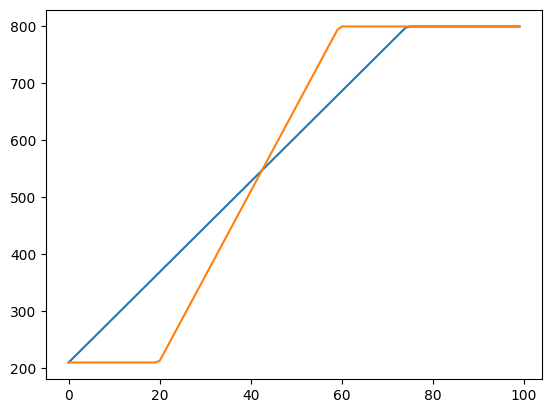

In [ ]:
init_sz = 200
pred_sz = 600
win_sz = init_sz+pred_sz
truncate_length = init_sz+10
plt.figure()
plt.plot([win_sz-sched_lin_p(win_sz-truncate_length,0,pct) for pct in np.linspace(0,1,100)])
plt.plot([win_sz-sched_ramp(win_sz-truncate_length,0,pct,0.2,0.6) for pct in np.linspace(0,1,100)])

In [ ]:
#| export
from fastai.callback.all import *
class CB_TruncateSequence(Callback):
    "`Callback` varies sequence length of every mini batch"
    def __init__(self, truncate_length = 50,scheduler=sched_ramp):
        self._truncate_length = truncate_length
        self._scheduler = scheduler

    def before_batch(self):
        if self.training:
            with torch.no_grad():
        #         import pdb; pdb.set_trace()
                lx = self.xb[0].shape[1]
                ly = self.yb[0].shape[1]
                lim = int(self._scheduler(ly-self._truncate_length,0,self.pct_train))
                if lim>0:
                    # print(lx,ly,lim)
            #         import pdb; pdb.set_trace()
                    self.learn.xb = tuple([x[:,:-lim] for x in self.xb])
                    self.learn.yb = tuple([y[:,:-lim] for y in self.yb])

In [ ]:
model = SimpleRNN(1,1)
Learner(dls,model,loss_func=nn.MSELoss(),cbs=CB_TruncateSequence(50,sched_lin_p)).fit(1)

epoch,train_loss,valid_loss,time
0,0.055499,0.057812,00:01


In [ ]:
#| export
class CB_AddLoss(Callback):
    '''Callback that adds the results of a given loss_function to the mini_batch after the original loss function has been applied'''
    def __init__(self,_loss_func,alpha=1.0):
        self._loss_func = _loss_func
        self.alpha = alpha
    
    def after_loss(self):
        if not self.training: return

        loss = self.alpha * self._loss_func(self.pred,self.y)
        self.learn.loss_grad = loss + self.learn.loss_grad
        self.learn.loss = loss + self.learn.loss

In [ ]:
model = SimpleRNN(1,1)
Learner(dls,model,loss_func=nn.MSELoss(),cbs=CB_AddLoss(nn.MSELoss(),alpha=10)).fit(1)

epoch,train_loss,valid_loss,time
0,0.629243,0.059755,00:01


In [ ]:
# #| export
# class BatchLossFilter(Callback):
#     """ 
#     Callback that selects the hardest samples in every batch representing a percentage of the total loss.
#     """
#     def __init__(self, loss_perc=1., filter_criterion=nn.HuberLoss(reduction='none'), schedule_func:Optional[callable]=None):
#         store_attr()  # Stores all passed arguments as class attributes

#     def before_batch(self):
#         """
#         Selects hardest samples before processing each batch.
#         """
#         if not self.training: return  # Skip if not in training mode
#         if self.schedule_func is None: loss_perc = self.loss_perc
#         else: loss_perc = self.loss_perc * self.schedule_func(self.pct_train)  # Adjust loss_perc if a schedule function is given
#         if loss_perc == 1.: return  # If loss_perc is 1, all samples are included, no need to filter

#         with torch.no_grad():  # No gradients needed for the filtering operation
#             losses = self.filter_criterion(self.learn.model(self.x), self.y)  # Compute individual losses
#             if losses.ndim >= 2: losses = losses.mean(tuple(range(1,losses.ndim)))  # If loss is multi-dimensional, take the mean over all but the first dimension
#             losses /= losses.sum()  # Normalize losses to make them sum up to 1
            
#             idxs = torch.argsort(losses, descending=True)  # Sort indices by loss
#             cut_idx = max(1, torch.argmax((losses[idxs].cumsum(0) > loss_perc).float()))  # Determine the cut-off index where cumulative sum exceeds loss_perc
#             idxs = idxs[:cut_idx]  # Select the hardest samples

#             self.learn.xb = tuple(xbi[idxs] for xbi in self.learn.xb)  # Filter the input batch
#             self.learn.yb = tuple(ybi[idxs] for ybi in self.learn.yb)  # Filter the output batch


In [ ]:
#| export
class BatchLossFilter(Callback):
    """ 
    Callback that selects the hardest samples in every batch representing a percentage of the total loss.
    """
    def __init__(self, loss_perc=1., filter_criterion=nn.HuberLoss(reduction='none'), schedule_func:Optional[callable]=None):
        store_attr() 

    def after_pred(self):
        """
        Selects hardest samples after model prediction and before loss computation.
        """
        if not self.training: return  # Skip if not in training mode
        if self.schedule_func is None: loss_perc = self.loss_perc
        else: loss_perc = self.loss_perc * self.schedule_func(self.pct_train)  # Adjust loss_perc if a schedule function is given
        if loss_perc == 1.: return  # If loss_perc is 1, all samples are included, no need to filter

        with torch.no_grad():  # No gradients needed for the filtering operation
            losses = self.filter_criterion(self.pred, self.y)  # Compute individual losses with model's predictions
            if losses.ndim >= 2: losses = losses.mean(tuple(range(1,losses.ndim)))  # If loss is multi-dimensional, take the mean over all but the first dimension
            losses /= losses.sum()  # Normalize losses to make them sum up to 1
            
            idxs = torch.argsort(losses, descending=True)  # Sort indices by loss
            cut_idx = max(1, torch.argmax((losses[idxs].cumsum(0) > loss_perc).float()))  # Determine the cut-off index where cumulative sum exceeds loss_perc
            idxs = idxs[:cut_idx]  # Select the hardest samples

        self.learn.xb = tuple(xbi[idxs] for xbi in self.learn.xb)  # Filter the input batch
        self.learn.yb = tuple(ybi[idxs] for ybi in self.learn.yb)  # Filter the output batch
        self.learn.pred = self.pred[idxs]  # Update the predictions to match the filtered batch

In [ ]:
# #| export
# class BatchLossFilter(Callback):
#     """ 
#     Callback that selects the hardest samples in every batch representing a percentage of the total loss.
#     """
#     order = -9
#     def __init__(self, loss_perc=1., filter_criterion=nn.HuberLoss(reduction='none'), schedule_func:Optional[callable]=None):
#         store_attr() 

#     def after_pred(self):
#         """
#         Calculate losses and select hardest samples after model prediction and before loss computation.
#         """
#         if not self.training: return  # Skip if not in training mode
#         if self.schedule_func is None: loss_perc = self.loss_perc
#         else: loss_perc = self.loss_perc * self.schedule_func(self.pct_train)  # Adjust loss_perc if a schedule function is given
#         if loss_perc == 1.: return  # If loss_perc is 1, all samples are included, no need to filter

#         with torch.no_grad():  # No gradients needed for the filtering operation
#             losses = self.filter_criterion(self.pred, *self.learn.yb)  # Compute individual losses with model's predictions
#             if losses.ndim >= 2: losses = losses.mean(tuple(range(1,losses.ndim)))  # If loss is multi-dimensional, take the mean over all but the first dimension
#             losses /= losses.sum()  # Normalize losses to make them sum up to 1
            
#             idxs = torch.argsort(losses, descending=True)  # Sort indices by loss
#             cut_idx = max(1, torch.argmax((losses[idxs].cumsum(0) > loss_perc).float()))  # Determine the cut-off index where cumulative sum exceeds loss_perc
#             self.idxs = idxs[:cut_idx]  # Store the indices of the hardest samples

#     def after_loss(self):
#         """
#         Recalculate the loss with the selected hardest samples.
#         """
#         if not self.training: return  # Skip if not in training mode
#         self.learn.loss_grad = self.loss_func(self.pred[self.idxs], *(yb[self.idxs] for yb in self.learn.yb))  # Compute the loss with hardest samples


In [ ]:
model = SimpleRNN(1,1)
Learner(dls,model,loss_func=nn.MSELoss(),cbs=BatchLossFilter(loss_perc=0.8)).fit(1)

epoch,train_loss,valid_loss,time
0,0.074184,0.059581,00:03


In [ ]:
#| export
from fastai.callback.hook import *
@delegates()
class TimeSeriesRegularizer(HookCallback):
    "Callback that adds AR and TAR to the loss, calculated by output of provided layer"
    run_before=TrainEvalCallback
    def __init__(self,alpha=0.0, beta=0.0,dim = None,detach=False, **kwargs):
        if 'modules' not in kwargs: print('Warning: No module was provided to TimeSerieRegularizer')
        super().__init__(detach=detach,**kwargs)
        store_attr('alpha,beta,dim')
        
    def hook(self, m, i, o): 
#         import pdb; pdb.set_trace()
        if isinstance(o,torch.Tensor):
            self.out = o
        else:
            self.out = o[0]
        
        #find time axis if not already provided
        if self.dim is None:
            self.dim = np.argmax([0,self.out.shape[1],self.out.shape[2]])
    
    def after_loss(self):
        if not self.training: return
        
        h = self.out.float()
        
        if self.alpha != 0.:  
            l_a = float(self.alpha) * h.pow(2).mean()
            self.learn.loss_grad += l_a 
            
        if self.beta != 0. and h.shape[self.dim]>1:
            h_diff = (h[:,1:] - h[:,:-1]) if self.dim == 1 else (h[:,:,1:] - h[:,:,:-1])
            l_b = float(self.beta) * h_diff.pow(2).mean()
            self.learn.loss_grad += l_b

In [ ]:
Learner(dls,model,loss_func=nn.MSELoss(),cbs=[TimeSeriesRegularizer(1.0,1.2,modules=[model.rnn])]).fit(1)

epoch,train_loss,valid_loss,time
0,0.053709,0.054955,00:01


In [ ]:
#| export
class ARInitCB(Callback):
    '''Adds the target variable to the input tuple for autoregression'''
    def before_batch(self):
#         import pdb; pdb.set_trace()
        self.learn.xb = tuple([*self.xb,*self.yb])

In [ ]:
Learner(dls,model,loss_func=nn.MSELoss()).fit(1)

epoch,train_loss,valid_loss,time
0,0.037985,0.027872,00:01


In [ ]:
#| export
from matplotlib.lines import Line2D
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    *modified version of https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063/8*
    
    Call multiple time for transparent overlays, representing the mean gradients
    '''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
#             pdb.set_trace()
            ave_grads.append(0 if p.grad is None else p.grad.abs().mean().cpu())
            max_grads.append(0 if p.grad is None else p.grad.abs().max().cpu())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("Gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.yscale('log')
    plt.tight_layout()
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

In [ ]:
#| export

class CB_PlotGradient(Callback):
    '''Plot the Gradient Distribution for every trainable parameter'''
    
    def __init__(self, n_draws=20): self.n_draws = n_draws
    
    def begin_fit(self):
        '''Create a new figure to plot in'''
        plt.figure()
        plt.tight_layout()
        
    def after_backward(self):
        '''plot the gradient for every layer of the current minibatch'''
        # plotting n_draws times at the whole training
        if self.iter % (max(self.n_epoch*self.n_iter//self.n_draws,1)) == 0:
#         if self.iter == self.n_iter-1:
            plot_grad_flow(self.learn.model.named_parameters())
#             print('done')

epoch,train_loss,valid_loss,time
0,0.021996,0.018407,00:01


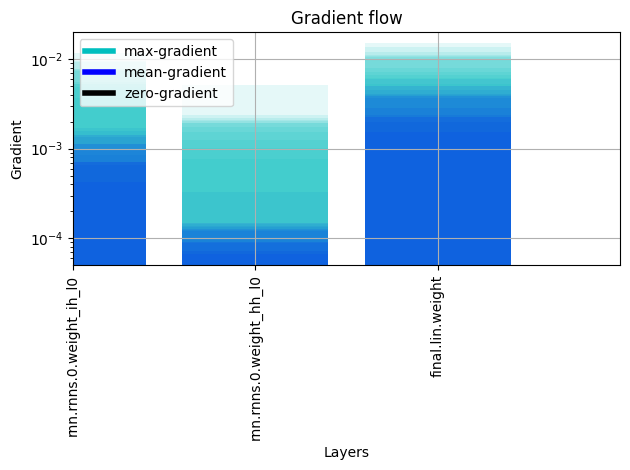

In [ ]:
Learner(dls,model,loss_func=nn.MSELoss(),cbs=CB_PlotGradient()).fit(1)

In [ ]:
#| include: false
import nbdev; nbdev.nbdev_export()